In [1]:
from scenario_runner import ScenarioRunner
from metadrive.examples.ppo_expert.torch_expert import torch_expert as expert
from pprint import pprint
from PIL import Image
import numpy as np

In [2]:
env = ScenarioRunner("crash_count", 123, decision_repeat=20).create_env()

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None


In [3]:
_, reset_info = env.reset()
crashed_vehicles = set()
frames = []

[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 123, Num Scenarios : 1


In [4]:
def max_touching_distance(ego, npc):
    ego_length, ego_width = ego.get_state()["length"], ego.get_state()["width"]
    npc_length, npc_width = npc.get_state()["length"], npc.get_state()["width"]

    # Pythagorean theorem
    dist = np.sqrt(
        (ego_length / 2 + npc_length / 2) ** 2 + (ego_width / 2 + npc_width / 2) ** 2
    )
    # add 10% just in case
    dist = dist * 1.1
    return dist

In [5]:
def get_crashed_vehicles(env) -> set:

    ret = set()
    ego = env.agent
    npcs = env.agent_manager.get_objects()

    # iterate over npc vehicles
    for npc in npcs.values():
        npc_state = npc.get_state()

        # if npc crashed
        if npc_state["crash_vehicle"]:

            # calculate distance beetween them
            distance = np.linalg.norm(ego.position - npc.position)

            # calculate max_touching_distance, (collision threshold)
            max_dist = max_touching_distance(ego, npc)

            # pprint(f"{distance = }")
            # pprint(f"{max_touching_distance(ego, npc) = }")

            if npc.id is not ego.id and distance < max_dist:
                ret.add(npc.id)

    return ret

In [6]:
for i in range(1500):

    action = expert(env.agent, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    frames.append(env.render(mode="topdown", window=False))

    if info["crash_vehicle"]:
        crashed_vehicles.update(get_crashed_vehicles(env))

    if terminated or truncated:
        break

[INFO] Use Torch PPO expert.
[INFO] Episode ended! Scenario Index: 123 Reason: arrive_dest.


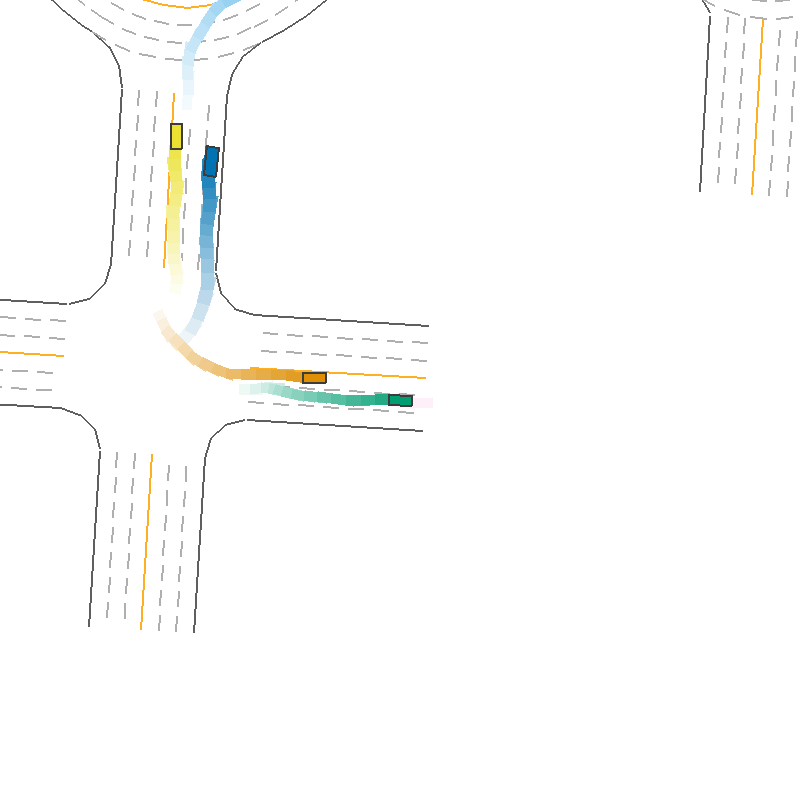

In [7]:
Image.fromarray(frames[-1])

In [8]:
crashed_vehicles

{'5c4d00ce-6e7c-4579-8ec5-ec3a0cc5b690',
 'd84d8490-9c69-49de-bf81-93a8df320ff4'}